In [6]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [7]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [8]:
hdf_dir = Path("../data")

In [198]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [259]:
fname = "2021_5_17.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<80} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1621281246 scan R3 F1=9_2 F=5                                                    : 760
1  <> 1621281928 scan R3 F1=9_2 F=5                                                    : 2721
2  <> 1621283409 scan R3 F1=9_2 F=5                                                    : 3421
3  <> 1621284527 scan R3 F1=9_2 F=5                                                    : 10311
4  <> 1621287463 scan R5 F1=13_2 F=7                                                   : 3401
5  <> 1621288498 scan R5 F1=13_2 F=7                                                   : 3401
6  <> 1621289898 scan R6 F1=15_2 F=8                                                   : 451
7  <> 1621290043 scan R6 F1=15_2 F=8                                                   : 951
8  <> 1621290409 scan R6 F1=15_2 F=8                                                   : 1067


### Detection laser beam is passed through the detection region twice, and then retroflected (going through a $\lambda/4$) for another two passes. Laser is elliptically expanded in height.

### All with phase modulation on detection

## Scan R3 F=5 F1'=9/2
43 mW

In [41]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [42]:
dset_idx = 0
dnames = [dset_names[dset_idx], dset_names[dset_idx+1]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

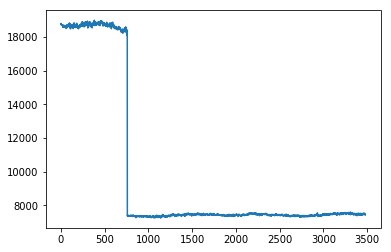

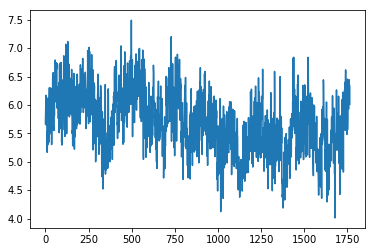

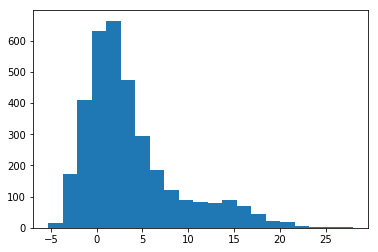

In [43]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [44]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -1e6

In [45]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

77.4% data discarded


In [56]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

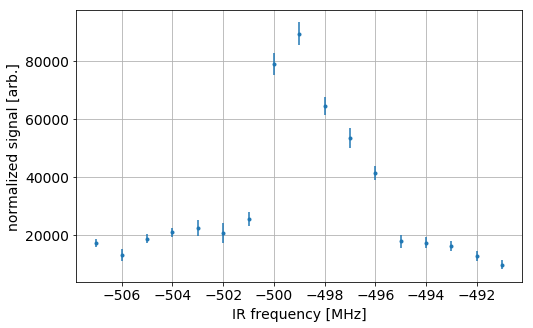

In [57]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [58]:
m = (~np.isnan(err))
bin_means = bin_means[m]
stat = stat[m]
err = err[m]

8.990457278542994
<Parameter 'center', value=-498.7043547421047 +/- 0.186, bounds=[-inf:inf]>
<Parameter 'fwhm', value=3.5935106104281855 +/- 0.328, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=13021.178107578162 +/- 2.16e+03, bounds=[-inf:inf]>


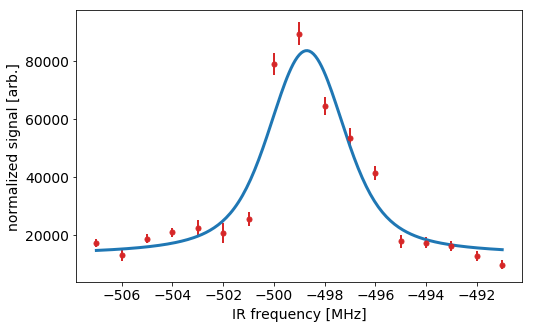

In [59]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])

In [60]:
traces_frequency = {}
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = pmt_data_norm[mt]
    traces_frequency[f] = dat[~np.isnan(dat[:,0])]

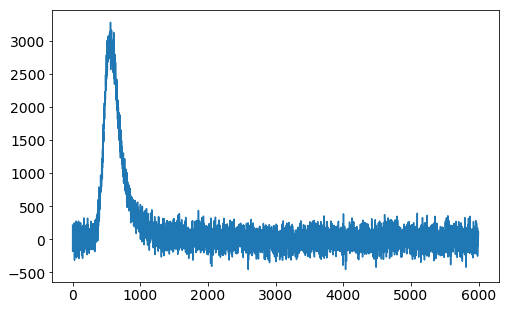

In [61]:
f = -499
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(traces_frequency[f].mean(axis = 0))
set_fontsize(ax, 14)

## Scan R3 F=5 F1'=9/2
43 mW

In [85]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [86]:
dset_idx = 2
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

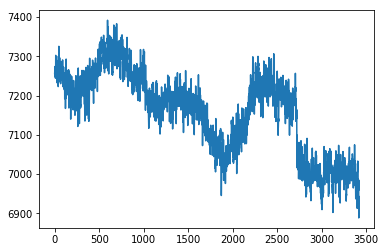

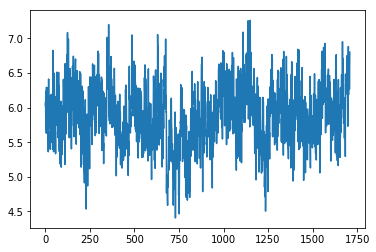

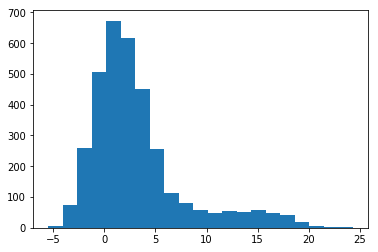

In [87]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [88]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -1e6

In [89]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

83.5% data discarded


In [90]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

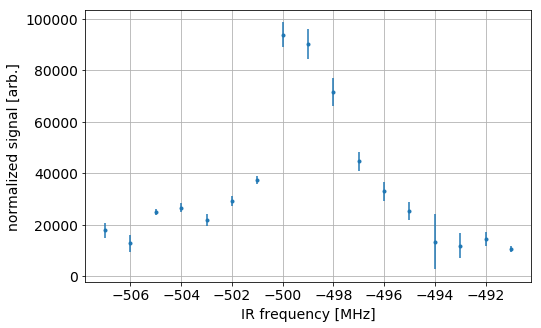

In [91]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [92]:
m = (~np.isnan(err))
bin_means = bin_means[m]
stat = stat[m]
err = err[m]

8.07916896438638
<Parameter 'center', value=-499.00301599747627 +/- 0.174, bounds=[-inf:inf]>
<Parameter 'fwhm', value=2.8750006769732233 +/- 0.27, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=16969.18980018637 +/- 2.16e+03, bounds=[-inf:inf]>


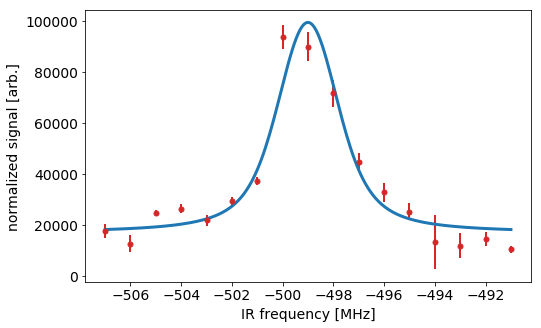

In [93]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])

In [94]:
traces_frequency = {}
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = pmt_data_norm[mt]
    traces_frequency[f] = dat[~np.isnan(dat[:,0])]

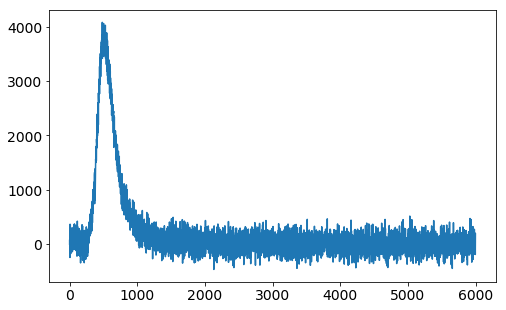

In [95]:
f = -499
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(traces_frequency[f].mean(axis = 0))
set_fontsize(ax, 14)

## Scan R3 F=5 F1'=9/2
41 mW

In [176]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [177]:
dset_idx = 3
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

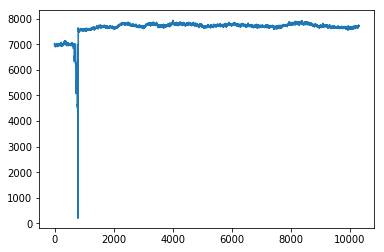

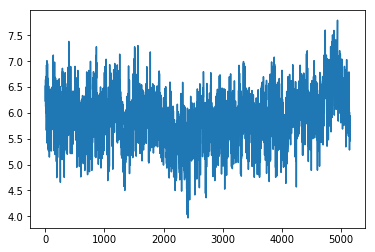

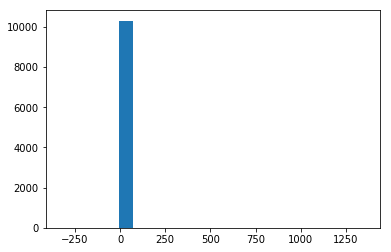

In [178]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [179]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -1e6

In [180]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

88.9% data discarded


In [181]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\CeNTREX\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


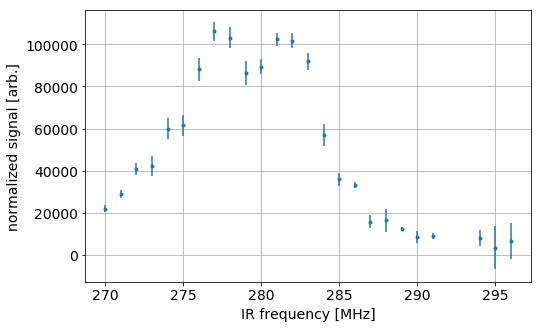

In [182]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [183]:
m = (~np.isnan(err))
bin_means = bin_means[m]
stat = stat[m]
err = err[m]

6.0688240150783095
<Parameter 'center', value=278.8988760117071 +/- 0.177, bounds=[-inf:inf]>
<Parameter 'fwhm', value=11.166211287265918 +/- 0.488, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=-5829.549368880953 +/- 4.23e+03, bounds=[-inf:inf]>


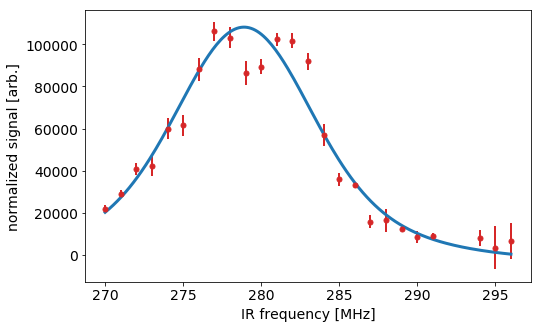

In [184]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])

In [185]:
traces_frequency = {}
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = pmt_data_norm[mt]
    traces_frequency[f] = dat[~np.isnan(dat[:,0])]

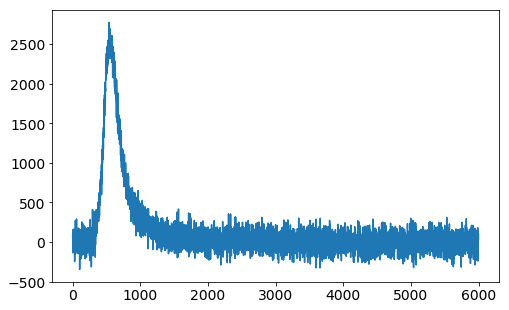

In [186]:
f = 280
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(traces_frequency[f].mean(axis = 0))
set_fontsize(ax, 14)

In [187]:
import math
from scipy.stats import binned_statistic_2d

def find_nearest_idx(array,value):
    """
    Get index of nearest item in array
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
nbins = 25
    
idx_pairs = {idx_pxie: find_nearest_idx(data_devices['ZaberTMM']['time'], t_pxie) for idx_pxie, t_pxie in pxie_time.items()}
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()

pxie_indices = np.array(list(idx_pairs.keys()))
zaber_indices = np.array(list(idx_pairs.values()))

indices_sort = np.argsort(pxie_indices)
pxie_indices = pxie_indices[indices_sort]
zaber_indices = zaber_indices[indices_sort]

# axes are flipped, e.g. axis 1 is y on the mirror mount and axis 2 is x
y_mirror = data_devices['ZaberTMM']['x'][zaber_indices]
x_mirror = data_devices['ZaberTMM']['y'][zaber_indices]

data = norm_data.copy()
data -= norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]

integral = np.trapz(data[:,slice_absi], axis = 1)

stat, x_edge, y_edge, _ = binned_statistic_2d(x_mirror, y_mirror, integral, lambda x: np.nanmean(x), bins = nbins, 
                                              expand_binnumbers = True)

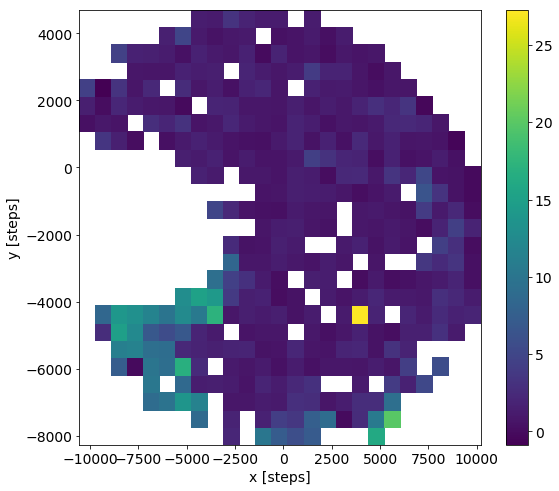

In [188]:
x_bin_width = np.diff(x_edge)[0]
y_bin_width = np.diff(y_edge)[0]
X, Y = np.meshgrid(x_edge,y_edge)

fig, ax = plt.subplots(figsize = (9,8))
cs = ax.pcolormesh(X,Y,stat)

cbar = fig.colorbar(cs)

ax.set_xlabel('x [steps]')
ax.set_ylabel('y [steps]')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Scan R5 F=7 F1'=13/2
41 mW

In [226]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [227]:
dset_idx = 4
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

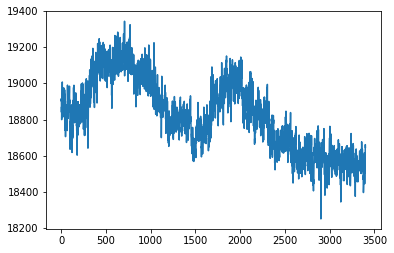

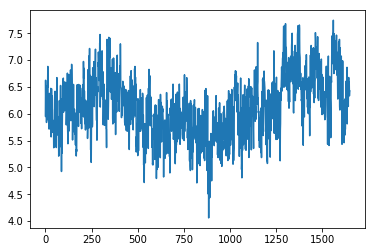

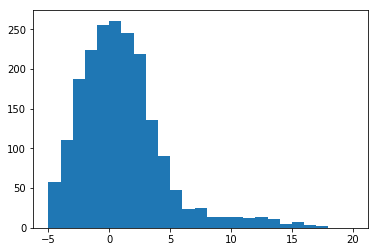

In [228]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [229]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -1e6

In [230]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

94.1% data discarded


In [231]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

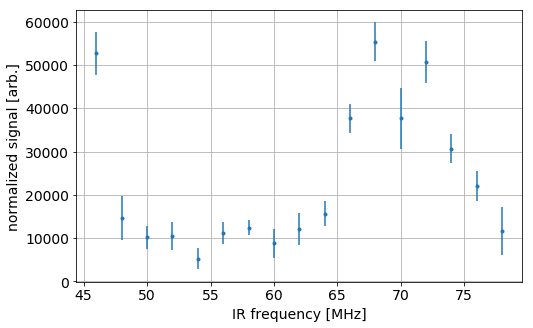

In [232]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [233]:
m = (~np.isnan(err))
bin_means = bin_means[m]
stat = stat[m]
err = err[m]

7.732880494020173
<Parameter 'center', value=69.81795570799514 +/- 0.647, bounds=[-inf:inf]>
<Parameter 'fwhm', value=7.429414359586396 +/- 1.3, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=9899.790201367978 +/- 3.1e+03, bounds=[-inf:inf]>


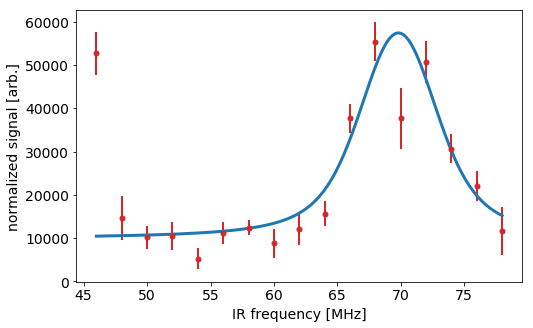

In [234]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])

## Scan R5 F=7 F1'=13/2
38 mW

In [235]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [236]:
dset_idx = 5
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

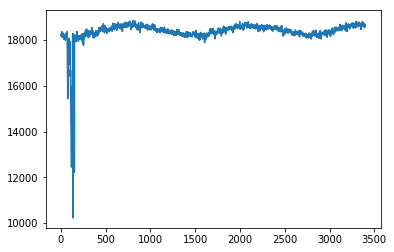

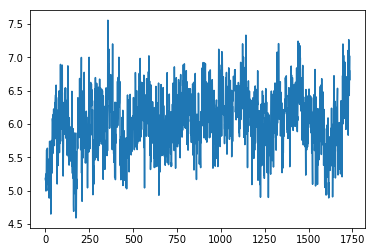

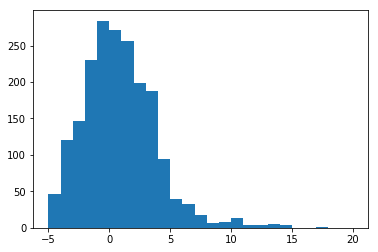

In [237]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [238]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -1e6

In [239]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

66.8% data discarded


In [240]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

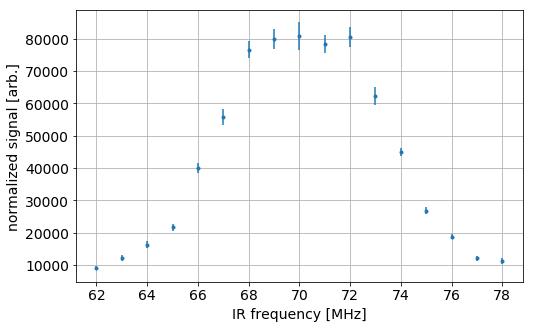

In [241]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [242]:
m = (~np.isnan(err))
bin_means = bin_means[m]
stat = stat[m]
err = err[m]

5.05845474145603
<Parameter 'center', value=70.16826288448623 +/- 0.0813, bounds=[-inf:inf]>
<Parameter 'fwhm', value=7.348990700868171 +/- 0.236, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=-1362.7011485077073 +/- 1.9e+03, bounds=[-inf:inf]>


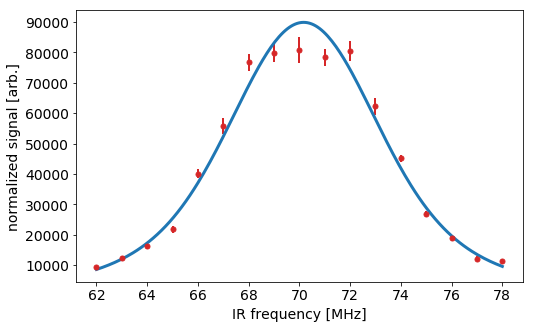

In [243]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])

In [244]:
import math
from scipy.stats import binned_statistic_2d

def find_nearest_idx(array,value):
    """
    Get index of nearest item in array
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
nbins = 25
    
idx_pairs = {idx_pxie: find_nearest_idx(data_devices['ZaberTMM']['time'], t_pxie) for idx_pxie, t_pxie in pxie_time.items()}
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()

pxie_indices = np.array(list(idx_pairs.keys()))
zaber_indices = np.array(list(idx_pairs.values()))

indices_sort = np.argsort(pxie_indices)
pxie_indices = pxie_indices[indices_sort]
zaber_indices = zaber_indices[indices_sort]

# axes are flipped, e.g. axis 1 is y on the mirror mount and axis 2 is x
y_mirror = data_devices['ZaberTMM']['x'][zaber_indices]
x_mirror = data_devices['ZaberTMM']['y'][zaber_indices]

data = norm_data.copy()
data -= norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]

integral = np.trapz(data[:,slice_absi], axis = 1)

stat, x_edge, y_edge, _ = binned_statistic_2d(x_mirror, y_mirror, integral, lambda x: np.nanmean(x), bins = nbins, 
                                              expand_binnumbers = True)

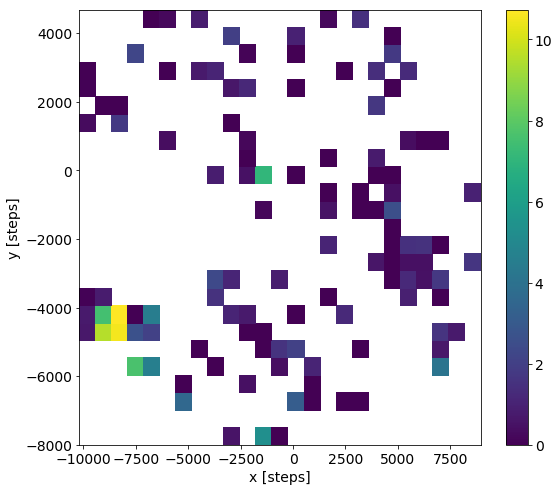

In [247]:
x_bin_width = np.diff(x_edge)[0]
y_bin_width = np.diff(y_edge)[0]
X, Y = np.meshgrid(x_edge,y_edge)

fig, ax = plt.subplots(figsize = (9,8))
cs = ax.pcolormesh(X,Y,stat, vmin = 0)

cbar = fig.colorbar(cs)

ax.set_xlabel('x [steps]')
ax.set_ylabel('y [steps]')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Scan R6 F=8 F1'=15/2
38 mW

In [250]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [251]:
dset_idx = 7
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

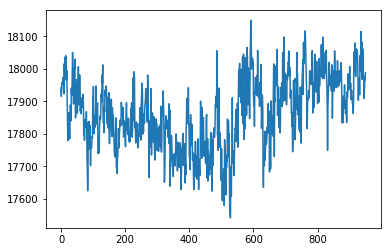

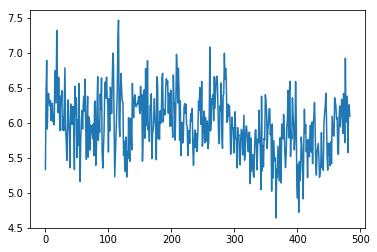

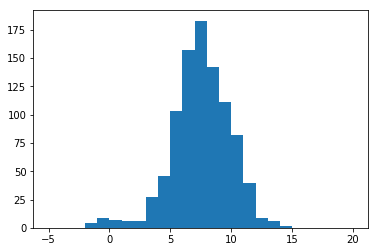

In [252]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [253]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -1e6

In [254]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

22.1% data discarded


In [255]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

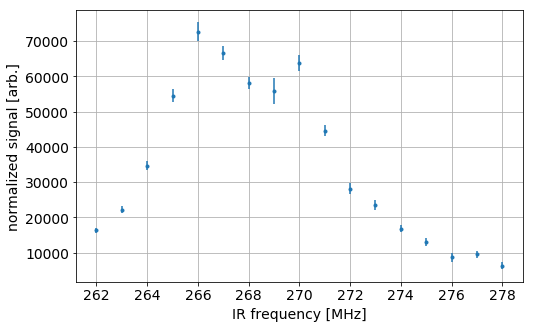

In [256]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [257]:
m = (~np.isnan(err))
bin_means = bin_means[m]
stat = stat[m]
err = err[m]

10.469862766824338
<Parameter 'center', value=267.8874499672554 +/- 0.151, bounds=[-inf:inf]>
<Parameter 'fwhm', value=7.684890251457231 +/- 0.396, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=982.2077957724761 +/- 2.87e+03, bounds=[-inf:inf]>


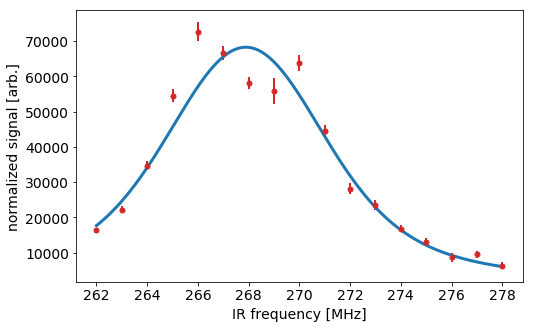

In [258]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])

## Scan R6 F=8 F1'=15/2
34 mW

In [260]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [261]:
dset_idx = 8
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

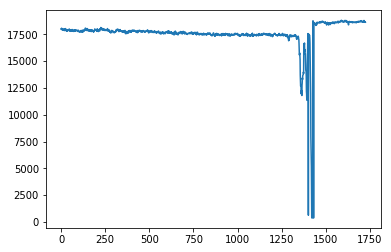

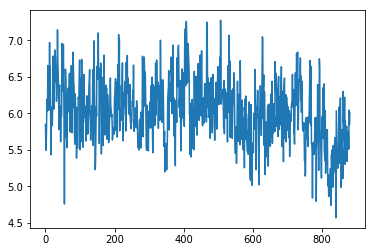

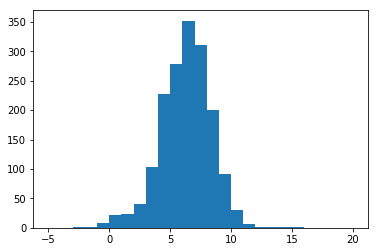

In [262]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [263]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -1e6

In [264]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

42.0% data discarded


In [265]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

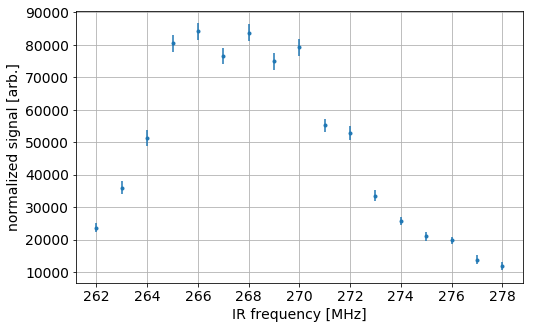

In [266]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [267]:
m = (~np.isnan(err))
bin_means = bin_means[m]
stat = stat[m]
err = err[m]

9.195999948588907
<Parameter 'center', value=267.8107613853282 +/- 0.174, bounds=[-inf:inf]>
<Parameter 'fwhm', value=8.427823068134096 +/- 0.46, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=4747.86124448783 +/- 3.74e+03, bounds=[-inf:inf]>


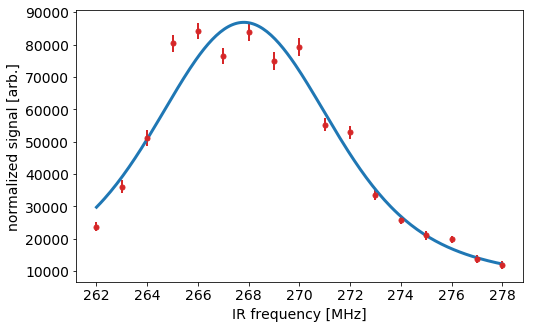

In [268]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])